# **Task-1**

In [79]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

In [80]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [81]:
train_dir = '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/Week 5/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/Week 5/FruitinAmazon/test'

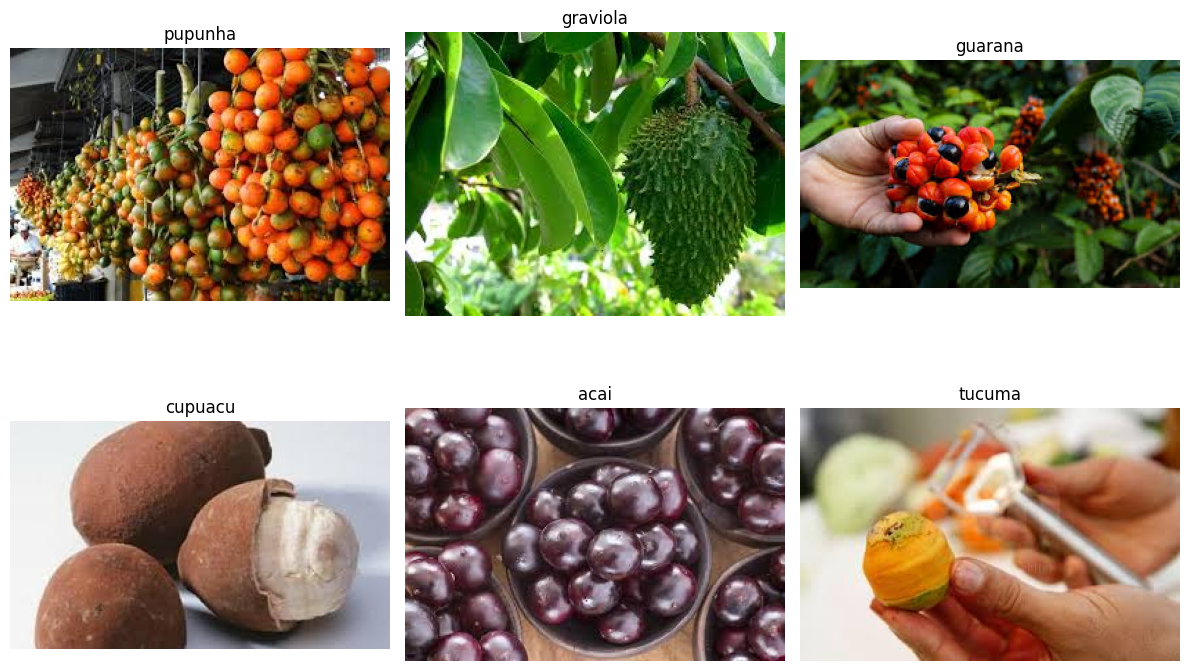

In [82]:
# list of class directories
class_dirs = os.listdir(train_dir)

# list to hold the images and labels
images = []
labels = []

for class_name in class_dirs:
  class_path = os.path.join(train_dir, class_name)
  image_files = os.listdir(class_path)

  # select a random image from each class
  random_image = random.choice(image_files)
  random_image_path = os.path.join(class_path, random_image)

  images.append(mpimg.imread(random_image_path))
  labels.append(class_name)

# plot the images in 2 rows, divide the columns accordingly
fig, axes = plt.subplots(nrows=2, ncols=len(class_dirs)//2, figsize=(12, 8))
axes = axes.ravel()

for i in range(len(images)):
  ax = axes[i]
  ax.imshow(images[i])
  ax.set_title(labels[i])
  ax.axis('off')

plt.tight_layout()
plt.show()

### **2. Check for Corrupted Image:**

Write a script that verifies whether the image in the train
directory are valid. If any corrupted images are found, the script must remove the image from the directory and print the message which image have been removed, if none found print ”No Corrupted Images Found.”

In [83]:
# list to store path to corrupted images
corrupted_images = []

# iterate through each class directory
for class_name in class_dirs:
  class_path = os.path.join(train_dir, class_name)
  # ensure it's a directory
  if os.path.isdir(class_path):
      # iterate through all image files in the class directory
      for image_name in os.listdir(class_path):
          image_path = os.path.join(class_path, image_name)

          #check if the file is an image (assuming common formats)
          if image_path.lower().endswith(('jpg', 'jpeg', 'png', 'gif')):
              try:
                  # try to open the image
                  with Image.open(image_path) as img:
                      img.verify()  # verify the image is not corrupted
                      width, height = img.size

                      # Print the height
              except (IOError, SyntaxError) as e:
                  # if an error occurs, it means the image is corrupted
                  corrupted_images.append(image_path)
                  os.remove(image_path)  # remove the corrupted image
                  print(f"Removed corrupted image: {image_path}")

# check if any corrupted images were found
if not corrupted_images:
    print("No corrupted images found.")

No corrupted images found.


In [84]:
# Data preparation
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2
)

# Create training and validation data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',
    seed=1337
)

# Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create validation generator without augmentations
validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  # Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [85]:
image_size = (128, 128)
batch_size = 64

In [86]:
def build_improved_model(input_shape=(128, 128, 3), num_classes=6):
    model = keras.Sequential([
        # Data augmentation and rescaling
        layers.Input(shape=input_shape),

        # First Conv Block
        layers.Conv2D(32, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Conv Block
        layers.Conv2D(64, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Conv Block
        layers.Conv2D(128, (3, 3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [87]:
# Create and compile model
model = build_improved_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [88]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1597 - loss: 2.6387

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.1713 - loss: 2.6528 - val_accuracy: 0.2222 - val_loss: 1.8606
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3264 - loss: 2.1226 - val_accuracy: 0.3333 - val_loss: 1.7460
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4444 - loss: 1.4147 - val_accuracy: 0.2222 - val_loss: 1.7639
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 932ms/step - accuracy: 0.4184 - loss: 1.6786 - val_accuracy: 0.2222 - val_loss: 1.6562
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 851ms/step - accuracy: 0.4525 - loss: 1.4627 - val_accuracy: 0.3889 - val_loss: 1.6584
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3889 - loss: 1.4053 - val_accuracy: 0.3333 - val_loss: 1.7827
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step - accuracy: 0.5972 - loss: 1.1142 - val_accuracy: 0.3333 - val_loss: 1.9533


In [89]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [90]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step - accuracy: 0.3000 - loss: 1.7186
Test accuracy: 0.3000


In [91]:
test_generator_1 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    seed=1337
)

Found 30 images belonging to 6 classes.


In [92]:
test_loss, test_acc = model.evaluate(test_generator_1)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accuracy: 0.3000 - loss: 1.7186
Test accuracy: 0.3000


# **Task-2**

In [93]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

In [94]:
class_names = sorted(os.listdir(train_dir))

In [95]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model except from block conv 5
base_model.trainable = True

set_trainable = False

for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_layer_12 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [96]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [97]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [98]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [99]:
# Display model summary
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 7,610,886 (29.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [100]:
# Create training and validation data generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training',
    seed=1337
)

# Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create validation generator without augmentations
validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  # Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [101]:
model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 73s 18s/step - accuracy: 0.1013 - loss: 1.9863 - val_accuracy: 0.1667 - val_loss: 1.8811
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 18s/step - accuracy: 0.1632 - loss: 1.8731 - val_accuracy: 0.2222 - val_loss: 1.8218
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 88s 26s/step - accuracy: 0.1684 - loss: 1.8083 - val_accuracy: 0.1667 - val_loss: 2.1750
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 61s/step - accuracy: 0.1944 - loss: 1.8875 - val_accuracy: 0.2222 - val_loss: 1.7709
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 61s/step - accuracy: 0.1435 - loss: 1.7763 - val_accuracy: 0.1667 - val_loss: 1.9388
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 17s/step - accuracy: 0.1539 - loss: 1.9120 - val_accuracy: 0.1667 - val_loss: 1.7857
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 68s 59s/step - accuracy: 0.1111 - loss: 1.8073 - val_accuracy: 0.2778 - val_loss: 1.7868
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 76s 26s/step - accuracy: 0.2263 - loss: 1.7861 - val_accuracy: 0.1667 - val_loss: 1.7900


# **Another Model**

### **Shape - 224**

In [102]:
train_generator_2 = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='training',
    seed=1337
)

# Create a separate ImageDataGenerator for validation (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create validation generator without augmentations
validation_generator_2 = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation',
    seed=1337,
    shuffle=False  # Important: Keep order consistent
)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [103]:
# Load pre-trained VGG16 model
base_model_224 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model_224.layers:
    layer.trainable = False

# Add custom layers on top
x224 = base_model_224.output
x224 = GlobalAveragePooling2D()(x224)
x224 = Dense(1024, activation='relu')(x224)
predictions224 = Dense(len(class_names), activation='softmax')(x224)

# Create final model
model224 = Model(inputs=base_model_224.input, outputs=predictions224)

# Compile the model
model224.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model224.summary()

# Train the model
history224 = model224.fit(
    train_generator_2,
    validation_data=validation_generator_2,
    epochs=15,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

# Evaluate the model
val_loss224, val_acc224 = model224.evaluate(validation_generator_2)
print(f"Validation Accuracy: {val_acc224:.4f}")

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 62s 17s/step - accuracy: 0.1302 - loss: 1.8905 - val_accuracy: 0.2222 - val_loss: 1.8561
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 16s/step - accuracy: 0.3750 - loss: 1.8088 - val_accuracy: 0.2778 - val_loss: 1.7831
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 68s 27s/step - accuracy: 0.2396 - loss: 1.7193 - val_accuracy: 0.3333 - val_loss: 1.6814
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 16s/step - accuracy: 0.3079 - loss: 1.5773 - val_accuracy: 0.2778 - val_loss: 1.6817
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 16s/step - accuracy: 0.3212 - loss: 1.5171 - val_accuracy: 0.2778 - val_loss: 1.6722
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 17s/step - accuracy: 0.4525 - loss: 1.4408 - val_accuracy: 0.4444 - val_loss: 1.6252
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 17s/step - accuracy: 0.5631 - loss: 1.3432 - val_accuracy: 0.3889 - val_loss: 1.5448
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 61s 17s/step - accuracy: 0.5289 - loss: 1.2331 - val_accuracy: 0.5000 - val_loss: 1.4124


In [104]:
# Ensure the validation generator does NOT shuffle
validation_generator_2.shuffle = False

# Get true labels
true_labels = validation_generator_2.classes

# Get class labels in correct order
class_labels = list(validation_generator_2.class_indices.keys())

# Make predictions
pred_probs = model224.predict(validation_generator_2)

# Convert predictions to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Classification Report
              precision    recall  f1-score   support

        acai       1.00      0.33      0.50         3
     cupuacu       0.50      1.00      0.67         3
    graviola       1.00      0.67      0.80         3
     guarana       0.50      0.67      0.57         3
     pupunha       0.00      0.00      0.00         3
      tucuma       0.60      1.00      0.75         3

    accuracy                           0.61        18
   macro avg       0.60      0.61      0.55        18
weighted avg       0.60      0.61      0.55        18



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator_2 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    seed=1337,
    shuffle=False
)

Found 30 images belonging to 6 classes.


In [106]:
# Evaluate the model
test_loss224, test_acc224 = model224.evaluate(test_generator_2)
print(f"Test Accuracy: {test_acc224:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - accuracy: 0.5000 - loss: 1.3652
Test Accuracy: 0.5000


In [107]:
# Ensure the validation generator does NOT shuffle
test_generator_2.shuffle = False

# Get true labels
true_labels = test_generator_2.classes

# Get class labels in correct order
class_labels = list(test_generator_2.class_indices.keys())

# Make predictions
pred_probs = model224.predict(test_generator_2)

# Convert predictions to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report")
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
Classification Report
              precision    recall  f1-score   support

        acai       0.50      0.20      0.29         5
     cupuacu       0.50      0.40      0.44         5
    graviola       0.71      1.00      0.83         5
     guarana       0.50      0.80      0.62         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.33      0.60      0.43         5

    accuracy                           0.50        30
   macro avg       0.42      0.50      0.43        30
weighted avg       0.42      0.50      0.43        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [108]:
# Print each sample's true vs. predicted label
print("\nTrue Label  |  Predicted Label")
print("-" * 30)

for i in range(len(true_labels)):
    true_class = class_labels[true_labels[i]]  # Get true class name
    pred_class = class_labels[pred_labels[i]]  # Get predicted class name
    print(f"{true_class:<12} |  {pred_class}")


True Label  |  Predicted Label
------------------------------
acai         |  acai
acai         |  guarana
acai         |  graviola
acai         |  cupuacu
acai         |  guarana
cupuacu      |  cupuacu
cupuacu      |  tucuma
cupuacu      |  cupuacu
cupuacu      |  guarana
cupuacu      |  tucuma
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
graviola     |  graviola
guarana      |  guarana
guarana      |  cupuacu
guarana      |  guarana
guarana      |  guarana
guarana      |  guarana
pupunha      |  tucuma
pupunha      |  guarana
pupunha      |  tucuma
pupunha      |  tucuma
pupunha      |  tucuma
tucuma       |  tucuma
tucuma       |  tucuma
tucuma       |  acai
tucuma       |  tucuma
tucuma       |  graviola
